# **Group - NameError - Predictive Analysis and Simulation in NBA**


---
![NBA](https://lasentinel.net/wp-content/uploads/sites/5/2019/05/New-NBA-Logo-1.png)
---



**Notes while running the codes:**

1. We are not running data manipulation script as it takes couple of hours to download. You can view the code and its output in the other files in the Codes section.

2. All the data has been stored in .csv files for your reference. For running our code, we are using the data stored in pickle files.

3. This is the main file which consists of KNN for MVP Prediction, Logistic model for match probability, entire match probability matrix and simulations for the current season.

4. We have simulated the tournament 500 times and displayed the results as 
1000 simulations will take around 15-20 mintutes. Before running that code fragment, ensure that the simulations are less (~50) so that the code doesn't take too long to run.

**Files and their description**:

1. **Scraping.ipynb** - In this file, we have scraped the data of NBA team and players from https://www.sports-reference.com/.

2. **Data Manipulation.ipynb** - In this file we have prepocessed the scraped data through data cleaning, removing null values, data imputation and transforming the data into useable format.

3. **KNN for MVP Prediction.ipynb** - This file addresses our first use-case of predicting the Most Valuable Player for the current NBA season using the K-Nearest Neighbours algorithm.

4. **Logistic Regression.ipynb** -In this file, we ran a logistic regression model to determine the probablility of a team winning in a match based on team player ratings for both the teams.

5. **Match probability calculation.ipynb** - Here, we use the logistic regression model to predict a team's probability of winning against all other teams.

6. **Simulations.ipynb** - Using the probablilities calculated for every fixture, we simulate the entire current NBA season to predict the champion of NBA 2019-20 in this file.

7. **Main File.ipynb** - This file is a summary of all the important use cases we have addressed so that it becomes easier to view the results.



# Setup

## Google Drive

In [1]:
!pip install sportsreference
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

## Import Packages

In [0]:
import pickle
import pandas as pd
import numpy as np
from sportsreference.nba.teams import Teams
from sportsreference.nba.roster import Roster
from sportsreference.nba.roster import Player
from sportsreference.nba.boxscore import Boxscore
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from statsmodels.formula.api import logit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from IPython import display
from IPython.display import clear_output 
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
import seaborn as sns
from datetime import datetime
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
np.random.seed(123)

## Load all data

In [3]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data/pickle/')
local_download_logos_path = os.path.expanduser('~/data/logos/')

## Load dataframes
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1e8GS0L0xUXQDgiRorx__FQViQjHNza7c' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

## Load Logos .jpg

try:
  os.makedirs(local_download_logos_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1yRrW4QMjLt9J0pPGhNboQMogFeCUe-F6' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_logos_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: nba19_schedule.pkl, id: 1dDDb1Z73WN-AdTQsM1uHz3I37J0-pkiO
downloading to /root/data/pickle/nba19_schedule.pkl
title: prob_df.pkl, id: 1hDp9GE3Bka9p9oiCbc8TrXFmnslxb2xz
downloading to /root/data/pickle/prob_df.pkl
title: Simulation_2019_20.xlsx, id: 1wUhiDOCQ1sYVab6GkbXzkBvXyBLbaCz4
downloading to /root/data/pickle/Simulation_2019_20.xlsx
title: logistic_model.pkl, id: 1r9655Pr_rfpAYjUj8Ev84OiNbhzc4TeB
downloading to /root/data/pickle/logistic_model.pkl
title: match_df_processed.pkl, id: 1ntpAAnbKO65Q_T7u-kec809CyURKXavp
downloading to /root/data/pickle/match_df_processed.pkl
title: all_players_data_all_season_processed.pkl, id: 1wuFPczmUxGikAqT-mKlu6uWhZXN9folv
downloading to /root/data/pickle/all_players_data_all_season_processed.pkl
title: all_players_data_all_season.pkl, id: 1Ngu5JnhvdPLE5VPo5LutFfZ2Q5uT9Lgg
downloading to /root/data/pickle/all_players_data_all_season.pkl
title: players_list.pkl, id: 17dLZoeKIEeAcS3ZffJf5kt_xEqUab6Gi
downloading to /root/data/pickle/players_l

## Download all required data

In [0]:
## List of files to download
file_names = ['nba19_schedule', 'players_list', 'match_df_processed', 'all_players_data_all_season_processed']
load_as = ['nba19_schedule', 'players_list', 'match_df', 'all_players_data']

## Download dile one by one
for name, df in zip(file_names, load_as):
  vars()[name + '_file'] = "/root/data/pickle/" + name + ".pkl"
  with open(vars()[name + '_file'], 'rb') as f:
    vars()[df] = pickle.load(f)

In [5]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data/logos/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1yRrW4QMjLt9J0pPGhNboQMogFeCUe-F6' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: was.png, id: 11dqc39lWTUJky5quQtz-k8vobmQp3GWt
downloading to /root/data/logos/was.png
title: sac.png, id: 1D3xMC2AXaz8qRdytZ9oHfRwEKdlJX5sm
downloading to /root/data/logos/sac.png
title: pho.png, id: 1OtDbmWzhS4TzHMBqWzqTz_0Yt9lyKrXU
downloading to /root/data/logos/pho.png
title: uta.png, id: 1Or6gvxb5UBR9K1tK8Af60KMpjyMV5NIM
downloading to /root/data/logos/uta.png
title: phi.png, id: 1IJvy1M4X4K2-4ge5KojH_7btRIPfLhXS
downloading to /root/data/logos/phi.png
title: okc.png, id: 1Rrflo5PY3IU6HgPpfeCpA9fqA9GO4oqB
downloading to /root/data/logos/okc.png
title: orl.png, id: 1TnqTdswmoo42HBRT2BL47PBSKqCbx3CA
downloading to /root/data/logos/orl.png
title: tor.png, id: 1Y3jv9amkcJAQDBdjObP-vn2n33l0ztXY
downloading to /root/data/logos/tor.png
title: por.png, id: 1xOC0v2KcP_4ULVtuce_kGQktuYHzqXt4
downloading to /root/data/logos/por.png
title: sas.png, id: 1_PpNLwPKrOn_25gOhGtg_NBJFcB3WH-m
downloading to /root/data/logos/sas.png
title: nyk.png, id: 12nPF9f22jBQLAMQp1RU4MsuYjJY3go7K
downlo

# KNN for MVP Prediction

## Data Preparation

#### Season data

In [0]:
seasons_consider = ['2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20']
all_players_data = all_players_data.loc[all_players_data['season'].isin(seasons_consider), :]

#### Set index

In [0]:
all_players_data = all_players_data.set_index(['season', 'player_name', 'player_id'])

#### Select columns

In [0]:
# Performance columns
perf_cols = [
            # 'assist_percentage',
            'assists',
            # 'block_percentage',
            # 'blocks',
            'box_plus_minus',
            'center_percentage',
            # 'defensive_box_plus_minus',
            # 'defensive_rebound_percentage',
            # 'defensive_rebounds',
            # 'defensive_win_shares',
            # 'dunks',
            'effective_field_goal_percentage',
            # 'field_goal_attempts',
            'field_goal_perc_sixteen_foot_plus_two_pointers',
            'field_goal_perc_ten_to_sixteen_feet',
            'field_goal_perc_three_to_ten_feet',
            # 'field_goal_perc_zero_to_three_feet',
            'field_goal_percentage',
            'field_goals',
            # 'free_throw_attempt_rate',
            'free_throw_attempts',
            'free_throw_percentage',
            'free_throws',
            'games_played',
            'games_started',
            # 'half_court_heaves',
            # 'half_court_heaves_made',
            'minutes_played',
            # 'offensive_box_plus_minus',
            # 'offensive_rebound_percentage',
            # 'offensive_rebounds',
            # 'offensive_win_shares',
            # 'percentage_field_goals_as_dunks',
            'percentage_of_three_pointers_from_corner',
            # 'percentage_shots_three_pointers',
            # 'percentage_shots_two_pointers',
            # 'percentage_sixteen_foot_plus_two_pointers',
            # 'percentage_ten_to_sixteen_footers',
            'percentage_three_to_ten_footers',
            # 'percentage_zero_to_three_footers',
            # 'personal_fouls',
            'player_efficiency_rating',
            'point_guard_percentage',
            'points',
            'power_forward_percentage',
            # 'shooting_distance',
            'shooting_guard_percentage',
            'small_forward_percentage',
            # 'steal_percentage',
            # 'steals',
            # 'three_point_attempt_rate',
            # 'three_point_attempts',
            # 'three_point_percentage',
            # 'three_point_shot_percentage_from_corner',
            # 'three_pointers',
            # 'three_pointers_assisted_percentage',
            # 'total_rebound_percentage',
            'total_rebounds',
            'true_shooting_percentage',
            'turnover_percentage',
            'turnovers',
            'two_point_attempts',
            # 'two_point_percentage',
            'two_pointers',
            'two_pointers_assisted_percentage',
            'usage_percentage',
            'win_shares',
            'win_shares_per_48_minutes'
              ]
all_players_data = all_players_data[perf_cols]

#### Train, cross-validation, and test split

In [0]:
# Train
Train = all_players_data.loc[['2013-14', '2014-15', '2015-16', '2016-17'],:]
# Val
Val1 = all_players_data.loc[['2017-18'],:]
Val2 = all_players_data.loc[['2018-19'],:]
# Test
Test = all_players_data.loc[['2019-20'],:]

## KNN Model

#### Scaling variables

In [0]:
scaler = StandardScaler()

# Train
scaler.fit(Train)

# Training data
Train_std = scaler.transform(Train)

# Validation data
Val1_std = scaler.transform(Val1)
Val2_std = scaler.transform(Val2)

# Test data
Test_std = scaler.transform(Test)

#### Define Model

In [0]:
model = NearestNeighbors(n_neighbors = 10)

#### Calculating cetroid of previous MVPs

In [0]:
index1 = Train.index.get_loc(('2013-14', 'Kevin Durant', 'duranke01'))
index2 = Train.index.get_loc(('2014-15', 'Stephen Curry', 'curryst01'))
index3 = Train.index.get_loc(('2015-16', 'Stephen Curry', 'curryst01'))
index4 = Train.index.get_loc(('2016-17', 'Russell Westbrook', 'westbru01'))
centroid = Train_std[[index1,index2,index3,index4],:].mean(axis = 0)

#### MVP prediction for season 2017-18 (Validation 1)

In [13]:
model.fit(Val1_std) 
distance, indices = model.kneighbors([centroid])

print(Val1.iloc[indices[0],:].index)

MultiIndex([('2017-18',          'James Harden', 'hardeja01'),
            ('2017-18',          'LeBron James', 'jamesle01'),
            ('2017-18',        'Damian Lillard', 'lillada01'),
            ('2017-18', 'Giannis Antetokounmpo', 'antetgi01'),
            ('2017-18',     'Russell Westbrook', 'westbru01'),
            ('2017-18',          'Kevin Durant', 'duranke01'),
            ('2017-18',         'DeMar DeRozan', 'derozde01'),
            ('2017-18',         'Anthony Davis', 'davisan02'),
            ('2017-18',        'Victor Oladipo', 'oladivi01'),
            ('2017-18',          'Kemba Walker', 'walkeke02')],
           names=['season', 'player_name', 'player_id'])


#### MVP prediction for season 2018-19 (Validation 2)



In [14]:
model.fit(Val2_std) 
distance, indices = model.kneighbors([centroid])

print(Val2.iloc[indices[0],:].index)

MultiIndex([('2018-19', 'Giannis Antetokounmpo', 'antetgi01'),
            ('2018-19',        'Damian Lillard', 'lillada01'),
            ('2018-19',          'James Harden', 'hardeja01'),
            ('2018-19',          'Kevin Durant', 'duranke01'),
            ('2018-19',           'Paul George', 'georgpa01'),
            ('2018-19',          'Nikola Jokić', 'jokicni01'),
            ('2018-19',          'Kemba Walker', 'walkeke02'),
            ('2018-19',         'Blake Griffin', 'griffbl01'),
            ('2018-19',          'Bradley Beal',  'bealbr01'),
            ('2018-19',    'Karl-Anthony Towns', 'townska01')],
           names=['season', 'player_name', 'player_id'])


#### MVP prediction for current season (Testing)

In [15]:
model.fit(Test_std) 
distance, indices = model.kneighbors([centroid])

print(Test.iloc[indices[0],:].index)

MultiIndex([('2019-20',          'James Harden', 'hardeja01'),
            ('2019-20', 'Giannis Antetokounmpo', 'antetgi01'),
            ('2019-20',           'Luka Dončić', 'doncilu01'),
            ('2019-20',          'LeBron James', 'jamesle01'),
            ('2019-20',         'Anthony Davis', 'davisan02'),
            ('2019-20',        'Damian Lillard', 'lillada01'),
            ('2019-20',            'Trae Young', 'youngtr01'),
            ('2019-20',          'Bradley Beal',  'bealbr01'),
            ('2019-20',    'Karl-Anthony Towns', 'townska01'),
            ('2019-20',      'Donovan Mitchell', 'mitchdo01')],
           names=['season', 'player_name', 'player_id'])


# Logistic regression for match prediction

##Select columns for model

In [0]:
cols = ['boxscore',
        'PG_home_rating', 
        'SG_home_rating', 
        'SF_home_rating', 
        'PF_home_rating', 
        'C_home_rating', 
        'bench_home_rating',
        'PG_away_rating', 
        'SG_away_rating', 
        'SF_away_rating', 
        'PF_away_rating', 
        'C_away_rating', 
        'bench_away_rating',
        'home_win_flag'    
        ]

match_df_model = match_df[cols].copy()

##Data split

In [0]:
# Shuffle
match_df_model_s = shuffle(match_df_model)

# Split
NBA_train = match_df_model_s[0:int(0.80*match_df_model_s.shape[0])]
NBA_test = match_df_model_s[int(0.80*match_df_model_s.shape[0]):]

##Train model

In [18]:
# Tuned model
model = logit(formula = 'home_win_flag~\
                        PG_home_rating+\
                        SG_home_rating+\
                        SF_home_rating+\
                        PF_home_rating+\
                        C_home_rating+\
                        bench_home_rating+\
                        PG_home_rating:PF_home_rating+\
                        PG_away_rating+\
                        SG_away_rating+\
                        SF_away_rating+\
                        PF_away_rating+\
                        C_away_rating+\
                        bench_away_rating+\
                        PG_away_rating:PF_away_rating', data = NBA_train).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.629826
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          home_win_flag   No. Observations:                 9342
Model:                          Logit   Df Residuals:                     9327
Method:                           MLE   Df Model:                           14
Date:                Sun, 15 Dec 2019   Pseudo R-squ.:                 0.07048
Time:                        21:40:27   Log-Likelihood:                -5883.8
converged:                       True   LL-Null:                       -6330.0
Covariance Type:            nonrobust   LLR p-value:                1.957e-181
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.5066      0.556     -0.912      0.

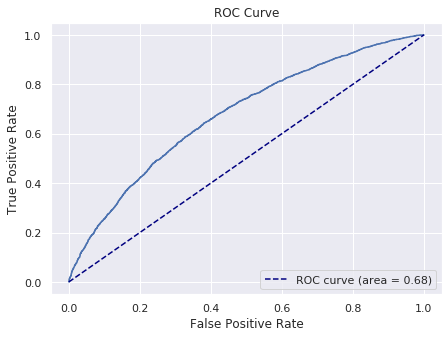

In [19]:
predictions = model.predict(NBA_train)

fpr, tpr, thresholds = roc_curve(NBA_train['home_win_flag'], predictions)
roc_auc = auc(fpr, tpr)

sns.set(rc={'figure.figsize':(7,5)})

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

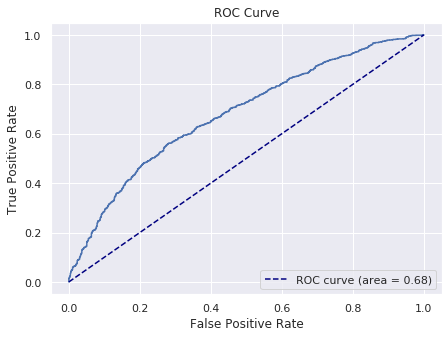

In [20]:
predictions = model.predict(NBA_test)

fpr, tpr, thresholds = roc_curve(NBA_test['home_win_flag'], predictions)
roc_auc = auc(fpr, tpr)

sns.set(rc={'figure.figsize':(7,5)})

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='ROC curve (area = %0.2f)' % roc_auc)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

#Match probability calculation for 2019-20 Season

##Get team names

In [0]:
team_names = []
team_ids = []
teams = Teams()
for team in teams:
    team_names.append(team.name)
    team_ids.append(team.abbreviation)

##Read excel for starting fives

In [0]:
team_raw_data = pd.DataFrame()
for team in team_ids:
  Tmp = pd.read_excel('/root/data/pickle/Simulation_2019_20.xlsx',sheet_name=team)
  Tmp['Team'] = team
  team_raw_data = pd.concat([team_raw_data, Tmp], ignore_index=True)

##Impute None

In [0]:
## Imputing None values with 15
team_raw_data.loc[team_raw_data['player_efficiency_rating'] == 'None','player_efficiency_rating'] = 15
## Convert column to int
team_raw_data['player_efficiency_rating'] = team_raw_data['player_efficiency_rating'].astype(int)

##Flooring for abnormally high rated players

In [0]:
team_raw_data.loc[team_raw_data['player_efficiency_rating'] >= 35, 'player_efficiency_rating'] = 15
team_raw_data.loc[team_raw_data['player_efficiency_rating'] < 0, 'player_efficiency_rating'] = 0

In [0]:
# long to wide format
team_raw_data = team_raw_data.groupby(['Team','final_position'])['player_efficiency_rating'].mean().reset_index()
Team_data = team_raw_data.pivot_table(values='player_efficiency_rating',index='Team',columns='final_position').reset_index().rename_axis("", axis="columns")

##Cartesian for team match-ups

In [0]:
Team_data = Team_data[['Team', 'PG', 'SG', 'SF', 'PF', 'C', 'Bench']]
Team_data['dummy_col'] = 1

Team_data = Team_data.merge(Team_data, left_on='dummy_col', right_on='dummy_col', how='inner').drop(columns=['dummy_col'])

Team_data.columns = ['Home_team',
                    'PG_home_rating',
                    'SG_home_rating',
                    'SF_home_rating',
                    'PF_home_rating',
                    'C_home_rating',
                    'bench_home_rating',
                    'Away_team',
                    'PG_away_rating',
                    'SG_away_rating',
                    'SF_away_rating',
                    'PF_away_rating',
                    'C_away_rating',
                    'bench_away_rating']

Team_data = Team_data.set_index(['Home_team', 'Away_team'])

##Predictions

In [0]:
predictions = model.predict(Team_data)
prob_df = predictions.unstack()

# Tournament Simulation

##Remove self match probabilities

In [0]:
for i in range(0,30):
  prob_df.iloc[i,i] = 0

##Define conference

In [0]:
# List of eastern and western conference teams
eastern_conference_teams = ['ATL','BRK','BOS','CHO','CHI','CLE','DET','IND','MIA','MIL','NYK','ORL','PHI','TOR','WAS']
western_conference_teams = ['DAL','DEN','GSW','HOU', 'LAC','LAL','MEM','MIN','NOP','OKC','PHO','POR','SAC','SAS','UTA']

##Define functions

###Initialize rankings

In [0]:
# Creating initial dataframe for eastern and western conference standings
def init_rankings(eastern_conference_teams, western_conference_teams):

  eastern = pd.DataFrame(data=np.full((15,2), 0), columns=['Win', 'Loss'], index=eastern_conference_teams)
  western = pd.DataFrame(data=np.full((15,2), 0), columns=['Win', 'Loss'], index=western_conference_teams)

  return eastern, western


### Update function for NBA ranking table 

In [0]:
def nba_ranking_table(winning_team, losing_team, eastern, western, ect, wct):
  
  if winning_team in ect and losing_team in ect:
    eastern.loc[winning_team]['Win'] += 1
    eastern.loc[losing_team]['Loss'] += 1

  elif winning_team in wct and losing_team in wct:
    western.loc[winning_team]['Win'] += 1
    western.loc[losing_team]['Loss'] += 1

  elif winning_team in ect and losing_team in wct:
    eastern.loc[winning_team]['Win'] += 1
    western.loc[losing_team]['Loss'] += 1

  else:
    western.loc[winning_team]['Win'] += 1
    eastern.loc[losing_team]['Loss'] += 1

  return eastern, western

###Get current rankings

In [0]:
def get_nba_ranking():
  from datetime import datetime
  today = datetime.today().strftime('%Y-%m-%d')
  today = np.datetime64(today, unit='s')

  current = nba19_schedule[nba19_schedule['datetime'] < today]

  eastern, western = init_rankings(eastern_conference_teams, western_conference_teams) 

  for i in range(current.shape[0]):
    t = nba19_schedule.iloc[i]['team_abbr']
    o = nba19_schedule.iloc[i]['opponent_abbr']

    if nba19_schedule.iloc[i]['result'] == 'Win':
      eastern, western = nba_ranking_table(t, o, eastern, western, eastern_conference_teams, western_conference_teams)
    else:
      eastern, western = nba_ranking_table(o, t, eastern, western, eastern_conference_teams, western_conference_teams)

  # Sorting both dataframes by win to get current standings from first to last
  eastern.sort_values(by='Win', ascending=False, inplace=True)
  western.sort_values(by='Win', ascending=False, inplace=True)

  return eastern, western

###Update rankings for simulated matches

In [0]:
def update_nba_ranking_table(winning_team, losing_team, e, w, ect, wct):

  eastern_simulated, western_simulated = nba_ranking_table(winning_team, losing_team, e, w, ect, wct)

  return eastern_simulated, western_simulated

###Match simulation function through bernoulli trials

In [0]:
def simulate_match(team, opponent, prob_df):
  p_team = prob_df.loc[team][opponent]  
  
  if np.random.random() < p_team:
    return team, opponent
  else:
    return opponent, team 

###Simulate rest of the regular season using schedule

In [0]:
def regular_season(nba19_schedule, prob_df, eastern_conference_teams, western_conference_teams):

  # this code snippet is for plotting a scatter plot of teams and wins as they proceed in the regular season
  # def getImage(path):
  #   return OffsetImage(plt.imread(path))

  today = datetime.today().strftime('%Y-%m-%d')
  today = np.datetime64(today, unit='s')
  future = nba19_schedule[nba19_schedule['datetime'] >= today]

  eastern_current, western_current = get_nba_ranking()

  e_simulated = eastern_current.copy(deep=True)
  w_simulated = western_current.copy(deep=True)

  # paths = ['/root/data/logos/{}.png'.format(x.lower()) for x in list(e_simulated.index)] + \
  #         ['/root/data/logos/{}.png'.format(x.lower()) for x in list(w_simulated.index)]

  # when match count reaches 30, scatter plot will be updated
  match_count = 0

  for i in range(future.shape[0]):
    team = future.iloc[i]['team_abbr']
    opponent = future.iloc[i]['opponent_abbr']
    winning_team, losing_team = simulate_match(team, opponent, prob_df)
    e_simulated, w_simulated = update_nba_ranking_table(winning_team, losing_team, e_simulated, w_simulated, eastern_conference_teams, western_conference_teams)

    # this code snippet is for plotting a scatter plot of teams and wins as they proceed in the regular season but takes time to load in Colab
    # match_count += 1 
    
    # if match_count == 29:
    #   match_count = 0
    #   fig, ax = plt.subplots(figsize=(22,12))
    #   display.clear_output(wait=True)
    #   x = pd.concat([e_simulated,w_simulated])
    #   ax.scatter(x.index,x['Win'])
    #   plt.ylim(0, 80)
        
    #   for x0, y0, path in zip(x.index, x['Win'],paths):
    #     ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    #     ax.add_artist(ab)
        
    #   plt.show()

  e_simulated.sort_values(by='Win', ascending=False, inplace=True)
  w_simulated.sort_values(by='Win', ascending=False, inplace=True)

  return e_simulated, w_simulated

In [0]:
def regular_season_with_plot(nba19_schedule, prob_df, eastern_conference_teams, western_conference_teams):

  # this code snippet is for plotting a scatter plot of teams and wins as they proceed in the regular season
  def getImage(path):
    return OffsetImage(plt.imread(path))

  today = datetime.today().strftime('%Y-%m-%d')
  today = np.datetime64(today, unit='s')
  future = nba19_schedule[nba19_schedule['datetime'] >= today]

  eastern_current, western_current = get_nba_ranking()

  e_simulated = eastern_current.copy(deep=True)
  w_simulated = western_current.copy(deep=True)

  paths = ['/root/data/logos/{}.png'.format(x.lower()) for x in list(e_simulated.index)] + \
          ['/root/data/logos/{}.png'.format(x.lower()) for x in list(w_simulated.index)]

  # when match count reaches 30, scatter plot will be updated
  match_count = 0

  for i in range(future.shape[0]):
    team = future.iloc[i]['team_abbr']
    opponent = future.iloc[i]['opponent_abbr']
    winning_team, losing_team = simulate_match(team, opponent, prob_df)
    e_simulated, w_simulated = update_nba_ranking_table(winning_team, losing_team, e_simulated, w_simulated, eastern_conference_teams, western_conference_teams)

    # this code snippet is for plotting a scatter plot of teams and wins as they proceed in the regular season but takes time to load in Colab
    match_count += 1 
    
    if match_count == 29:
      match_count = 0
      fig, ax = plt.subplots(figsize=(22,12))
      display.clear_output(wait=True)
      x = pd.concat([e_simulated,w_simulated])
      ax.scatter(x.index,x['Win'])
      plt.ylim(0, 80)
        
      for x0, y0, path in zip(x.index, x['Win'],paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)
        
      plt.show()

  e_simulated.sort_values(by='Win', ascending=False, inplace=True)
  w_simulated.sort_values(by='Win', ascending=False, inplace=True)

  return e_simulated, w_simulated

###Best of 7 simulations for Playoffs

In [0]:
def play_seven_games(team, opponent):
 # record number of wins for team and opponent
 stats = {team: 0, opponent: 0}

 # seven games in every round for every match pair in 2-2-1-1-1 fashion
 for i in range(2):
   w, _ = simulate_match(team, opponent, prob_df)
   stats[w] += 1
   
 for i in range(2):
   w, _ = simulate_match(opponent, team, prob_df)
   stats[w] += 1
   
 w, _ = simulate_match(team, opponent, prob_df)
 stats[w] += 1
   
 w, _ = simulate_match(opponent, team, prob_df)
 stats[w] += 1
   
 w, _ = simulate_match(team, opponent, prob_df)
 stats[w] += 1

 if stats[team] > stats[opponent]:
   return team

 else:
   return opponent

###First round of Playoffs

In [0]:
def first_round(e_simulated, w_simulated):
  e_qualified = list(e_simulated.index)[0:8]
  w_qualified = list(w_simulated.index)[0:8]

  eastern_first_round_matches = [(e_qualified[0], e_qualified[7]), (e_qualified[1], e_qualified[6]), (e_qualified[2], e_qualified[5]), (e_qualified[3], e_qualified[4])]
  western_first_round_matches = [(w_qualified[0], w_qualified[7]), (w_qualified[1], w_qualified[6]), (w_qualified[2], w_qualified[5]), (w_qualified[3], w_qualified[4])]

  eastern_sf_qualified = []
  western_sf_qualified = []

  for game in eastern_first_round_matches:
    eastern_sf_qualified.append(play_seven_games(game[0], game[1]))

  for game in western_first_round_matches:
    western_sf_qualified.append(play_seven_games(game[0], game[1]))
  

  return eastern_sf_qualified, western_sf_qualified

###Conference semifinals

In [0]:
def conference_semifinals(eastern_sf, western_sf):
  eastern_sf_matches = [(eastern_sf[0], eastern_sf[3]), (eastern_sf[1], eastern_sf[2])]
  western_sf_matches = [(western_sf[0], western_sf[3]), (western_sf[1], western_sf[2])]

  eastern_finals_qualified = []
  western_finals_qualified = []

  for game in eastern_sf_matches:
    eastern_finals_qualified.append(play_seven_games(game[0], game[1]))

  for game in western_sf_matches:
    western_finals_qualified.append(play_seven_games(game[0], game[1]))

  return eastern_finals_qualified, western_finals_qualified

###Conference finals

In [0]:
def conference_finals(eastern_finals, western_finals):
  nba_finals = []

  nba_finals.append(play_seven_games(eastern_finals[0], eastern_finals[1]))
  nba_finals.append(play_seven_games(western_finals[0], western_finals[1]))

  return nba_finals

###NBA Finals

In [0]:
def nba_tournament_finals(nba_finals):
  champion = play_seven_games(nba_finals[0], nba_finals[1])

  return champion

##Sample simulation for regular season

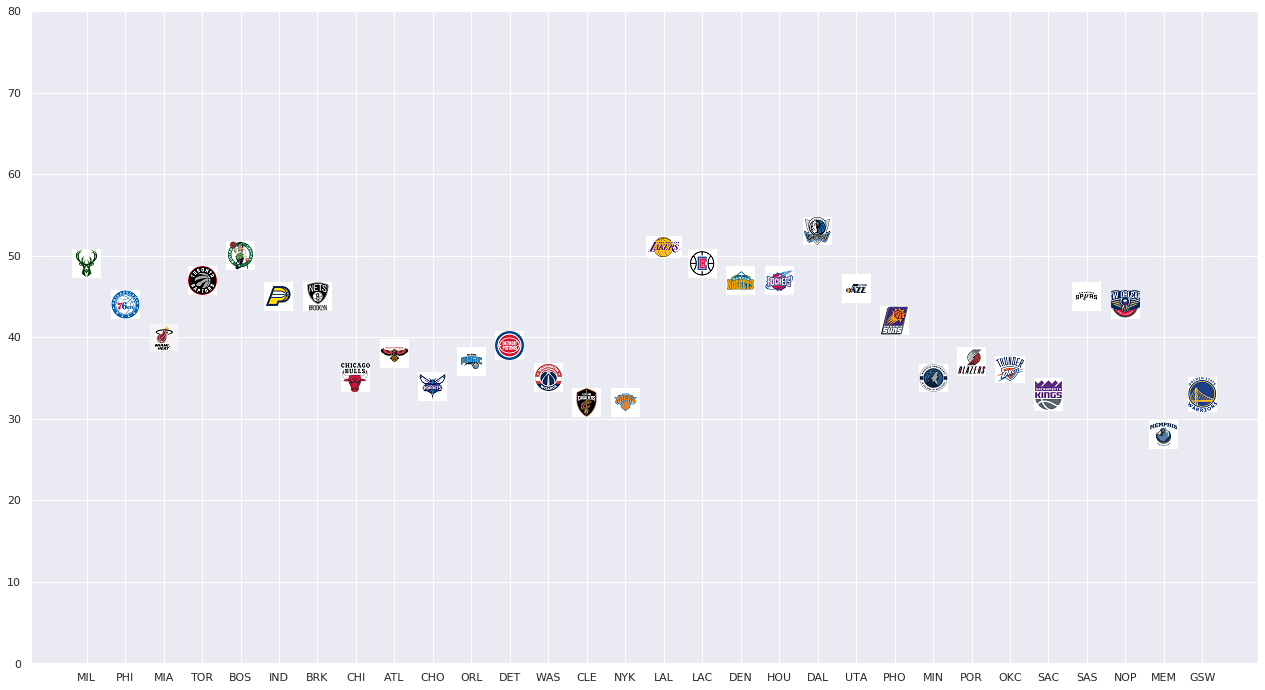

In [42]:
e_simulated_regular_season, w_simulated_regular_season = regular_season_with_plot(nba19_schedule, prob_df, eastern_conference_teams, western_conference_teams)

##Run multiple simulations for the entire tournament

In [0]:
nba_champion_df = pd.DataFrame(data=np.full((30,1), 0), columns=['NBA Champion'], \
                               index=eastern_conference_teams+western_conference_teams)

# doing 1000 simulations - doing 50 right now as 1000 will take 20 mins to run 
for i in range(500):
  e_simulated_regular_season, w_simulated_regular_season = regular_season(nba19_schedule, prob_df, eastern_conference_teams, western_conference_teams)
  eastern_sf_qualified, western_sf_qualified = first_round(e_simulated_regular_season, w_simulated_regular_season)
  eastern_finals_qualified, western_finals_qualified = conference_semifinals(eastern_sf_qualified, western_sf_qualified)
  nba_finals = conference_finals(eastern_finals_qualified, western_finals_qualified)
  champion = nba_tournament_finals(nba_finals)
  nba_champion_df.loc[champion]['NBA Champion'] += 1
  # code snippet to plot the number of wins for each team
#   plt.figure(figsize=(22,12))
#    display.clear_output(wait=True)
#    plt.bar(nba_champion_df.index,nba_champion_df['NBA Champion'])
#    plt.ylim(0, 300)

#    plt.show()

##Final Standings

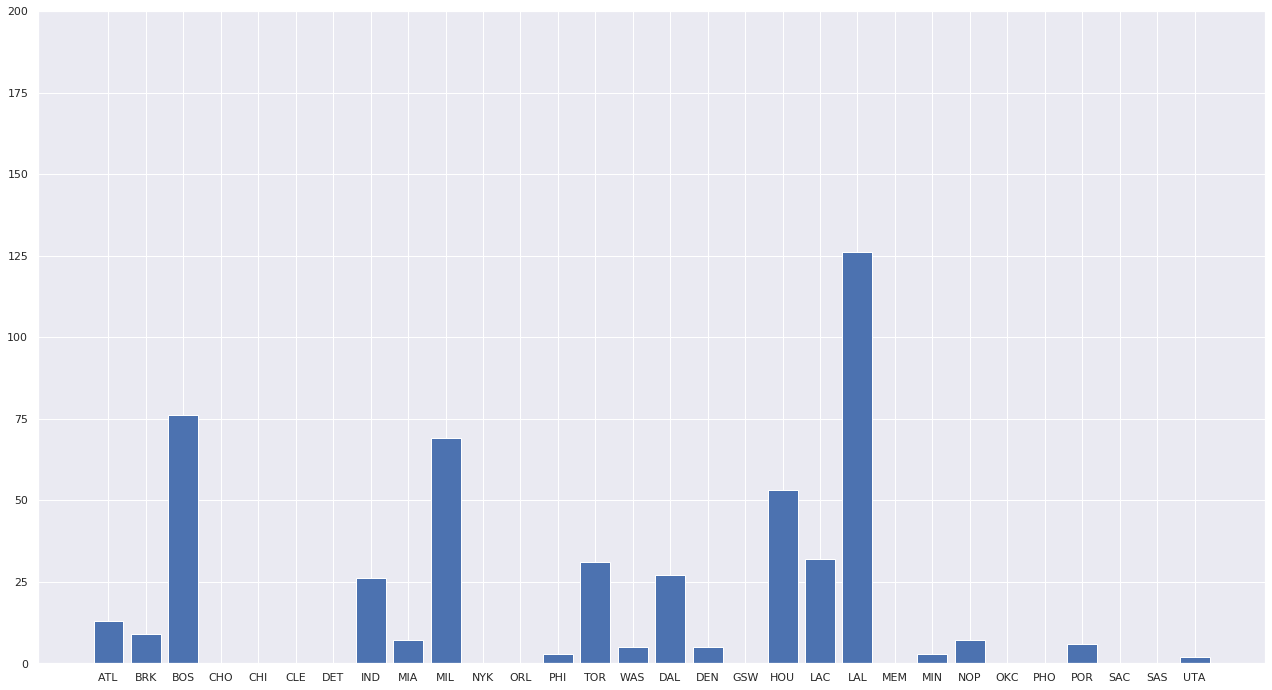

In [44]:
plt.figure(figsize=(22,12))
plt.bar(nba_champion_df.index,nba_champion_df['NBA Champion'])
plt.ylim(0, 200)
plt.show()